In [183]:
##load saved bm.keras and optimize it and then also train on test data and train data then upload final 













#default ml libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as sk
#tf libraries
import tensorflow as tf
import tensorflow as tf
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import itertools
import pandas as pd
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
#import kfold from sklearn
from sklearn.model_selection import KFold
from termcolor import colored

In [184]:
# Load the test.csv file
DEV = True
loaddata = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')

In [185]:
train = loaddata.copy()
print(train.head())
print()
print()
print()
print()
test = testdata.copy()
print(test.head())

   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
0              

In [186]:
# feature engineering
test["loantoincome"] = ((test["loan_amnt"] / test["person_income"])).astype('Float64')
test["loan_percent_incometoincome"] = ((test["loan_percent_income"] / test["person_income"])).astype('Float64')
test['person_age_to_person_income'] = (test['person_age'] / test['person_income']).astype(str).astype('Float64')
test['person_emp_length_to_person_age'] = (test['person_emp_length'] / test['person_age']).astype('Float64')
test['loan_int_rate_to_loan_amnt'] = (test['loan_int_rate'] / test['loan_amnt']).astype('Float64')



test['income_to_age'] = test['person_income'] / test['person_age']
test['loan_to_income'] = test['loan_amnt'] / test['person_income']
test['rate_to_loan'] = test['loan_int_rate'] / test['loan_amnt']















test['log_income'] = (np.log1p(test['person_income'])).astype('Float64')
test['age_credit_history_interaction'] = (test['person_age'] * test['cb_person_cred_hist_length']).astype('float64')
test['high_loan_to_income'] = (test['loan_percent_income'] > 0.5).astype('float64')
test['is_new_credit_user'] = (test['cb_person_cred_hist_length'] < 2).astype('float64')
test['high_interest_rate'] = (test['loan_int_rate'] > test['loan_int_rate'].mean()).astype('float64')
test['loan_to_employment'] = test['loan_amnt'] / (test['person_emp_length'] + 1)
test['rate_to_grade'] = test.groupby('loan_grade')['loan_int_rate'].transform('mean')


def categorize_age(age):
    if age <= 25:
        return 0
    elif age <= 35:
        return 1
    elif age <= 45:
        return 2
    elif age <= 55:
        return 3
    else:
        return 4

# test['income_category'] = pd.qcut(test['person_income'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
# test['intent_grade_interaction'] = test['loan_intent'].astype(str) + '_' + test['loan_grade'].astype(str)
# test['home_ownership_intent'] = test['person_home_ownership'].astype(str) + '_' + test['loan_intent'].astype(str)

# Function to calculate and store quantiles



test['age_category'] = test['person_age'].apply(categorize_age).astype('category')










test['person_home_ownership'] = test['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
test['loan_intent'] = test['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
test['loan_grade'] = test['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}).astype('category')
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')
test["person_home_ownership_income"] = pd.Series(pd.factorize((test["person_home_ownership"].astype(str) + test["person_income"].astype(str)).to_numpy())[0]).astype('category')

test['person_home_ownership_income'].unique()

/tmp/ipykernel_120294/4078911324.py:68: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['person_home_ownership'] = test['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
/tmp/ipykernel_120294/4078911324.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test['loan_intent'] = test['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
/tmp/ipykernel_120294/4078911324.py:70: FutureWar

[0, 1, 2, 3, 4, ..., 3136, 3137, 3138, 3139, 3140]
Length: 3141
Categories (3141, int64): [0, 1, 2, 3, ..., 3137, 3138, 3139, 3140]

In [187]:
# feature engineering
train["loantoincome"] = ((train["loan_amnt"] / train["person_income"])).astype('Float64')
train["loan_percent_incometoincome"] = ((train["loan_percent_income"] / train["person_income"])).astype('Float64')
train['person_age_to_person_income'] = (train['person_age'] / train['person_income']).astype(str).astype('Float64')
train['person_emp_length_to_person_age'] = (train['person_emp_length'] / train['person_age']).astype('Float64')
train['loan_int_rate_to_loan_amnt'] = (train['loan_int_rate'] / train['loan_amnt']).astype('Float64')


train['income_to_age'] = train['person_income'] / train['person_age']
train['rate_to_loan'] = train['loan_int_rate'] / train['loan_amnt']
train['person_home_ownership'] = train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
train['loan_intent'] = train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
train['loan_grade'] = train['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}).astype('category')
train['cb_person_default_on_file'] = train['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}).astype('category')
train["person_home_ownership_income"] = pd.Series(pd.factorize((train["person_home_ownership"].astype(str) + train["person_income"].astype(str)).to_numpy())[0]).astype('category')




train['log_income'] = np.log1p(train['person_income']).astype('float64')
train['age_credit_history_interaction'] = (train['person_age'] * train['cb_person_cred_hist_length']).astype('float64')
train['high_loan_to_income'] = (train['loan_percent_income'] > 0.5).astype('float64')
train['is_new_credit_user'] = (train['cb_person_cred_hist_length'] < 2).astype('float64')
train['high_interest_rate'] = (train['loan_int_rate'] > train['loan_int_rate'].mean()).astype('float64')
train['loan_to_employment'] = (train['loan_amnt'] / (train['person_emp_length'] + 1)).astype('float64')
train['rate_to_grade'] = train.groupby('loan_grade')['loan_int_rate'].transform('mean').astype('float64')
train['age_category'] = train['person_age'].apply(categorize_age).astype('category')















# df['risk_score'] = df['loan_percent_income'] * df['loan_int_rate'] * (5 - df['loan_grade'].map({'A':5, 'B':4, 'C':3, 'D':2, 'E':1, 'F':0, 'G':0}))
# df['age_to_credit_history'] = df['person_age'] / (df['cb_person_cred_hist_length'] + 1)
# df['income_home_mismatch'] = ((df['person_income'] > df['person_income'].quantile(0.8)) & (df['person_home_ownership'] == 'RENT')).astype(int)
# df['default_grade_interaction'] = df['cb_person_default_on_file'].astype(str) + '_' + df['loan_grade'].astype(str)
# df['normalized_loan_amount'] = df.groupby('loan_intent')['loan_amnt'].transform(lambda x: (x - x.mean()) / x.std())
# df['income_to_loan'] = df['person_income'] / df['loan_amnt']
# df['log_loan_amnt'] = np.log1p(df['loan_amnt'])





















# Function to calculate and store quantiles in a dictionary
def calculate_quantiles(data, column):
    quantiles = {}
    for q in [0.2, 0.4, 0.6, 0.8]:
        quantiles[f'q{int(q*100)}'] = data[column].quantile(q)
    return quantiles

# Calculate quantiles for the train dataset
income_quantiles = calculate_quantiles(train, 'person_income')

# Function to categorize income using cached quantiles
def categorize_income(income, quantiles):
    if income <= quantiles['q20']:
        return 0
    elif income <= quantiles['q40']:
        return 0.1
    elif income <= quantiles['q60']:
        return 0.2
    elif income <= quantiles['q80']:
        return 0.3
    else:
        return 0.4

# Apply the categorize_income function to create the income_category column
train['income_category'] = train['person_income'].apply(categorize_income, args=(income_quantiles,)).astype('category')
test['income_category'] = test['person_income'].apply(categorize_income, args=(income_quantiles,)).astype('category')














# Add the transformed columns


train['loan_intent_grade'] = ((train['loan_intent'].astype('float64') * 10 + train['loan_grade'].astype('float64'))/100).astype('category')
test['loan_intent_grade'] = ((test['loan_intent'].astype('float64') * 10 + test['loan_grade'].astype('float64'))/100).astype('category')
 

# more feature engineering

train['loan_intent_grade'].unique()


/tmp/ipykernel_120294/699656101.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['person_home_ownership'] = train['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}).astype('category')
/tmp/ipykernel_120294/699656101.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['loan_intent'] = train['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}).astype('category')
/tmp/ipykernel_120294/699656101.py:13: FutureWa

[0.01, 0.12, 0.20, 0.31, 0.10, ..., 0.16, 0.56, 0.26, 0.06, 0.46]
Length: 42
Categories (42, float64): [0.00, 0.01, 0.02, 0.03, ..., 0.53, 0.54, 0.55, 0.56]

In [188]:
#delete all files that start with lgbm and xgb 

for item in os.listdir():
    if item.startswith("lgbm") or item.startswith("xgb"):
        os.remove(item)

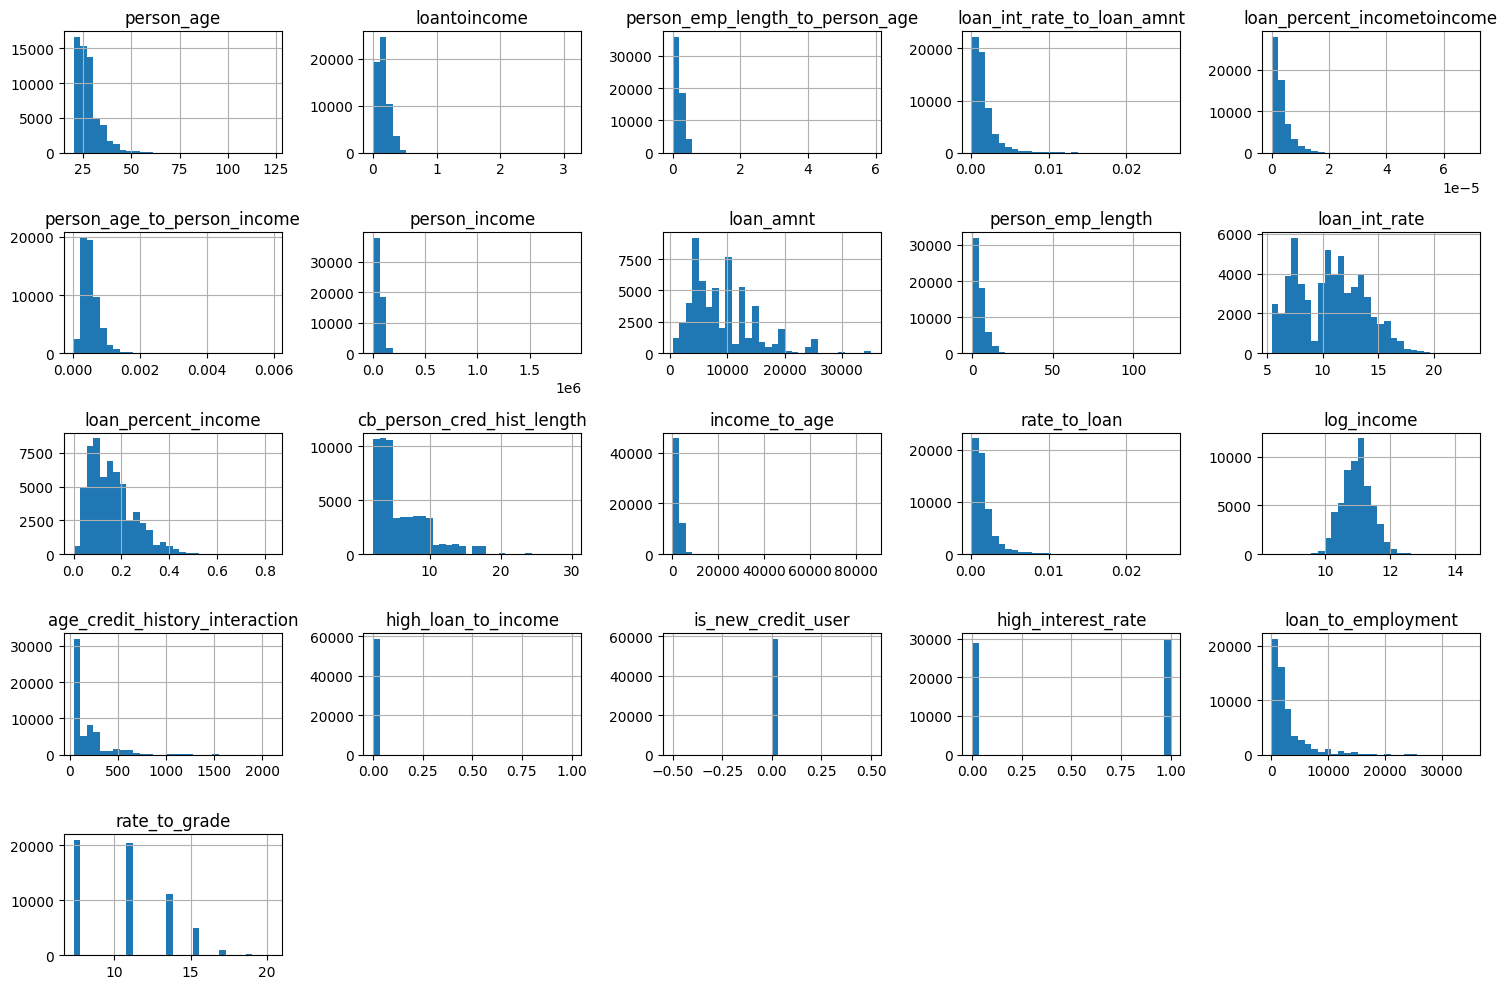

loan_status
0    50295
1     8350
Name: count, dtype: int64
loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64



In [189]:



# Plot histograms for numerical columns
numerical_columns = ['person_age','loantoincome','person_emp_length_to_person_age',
                     'loan_int_rate_to_loan_amnt','loan_percent_incometoincome',
                     'person_age_to_person_income','person_income', 'loan_amnt',"person_emp_length" ,
                     'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length','income_to_age','rate_to_loan','log_income',
                     'age_credit_history_interaction','high_loan_to_income','is_new_credit_user','high_interest_rate','loan_to_employment','rate_to_grade',
                     ]
train[numerical_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Plot count plots for categorical columns
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_status',
    "person_home_ownership_income",
    'age_category',
    'loan_intent_grade',
    'income_category',
    # 'intent_grade_interaction','home_ownership_intent'
]
numerical_features = numerical_columns
categorical_features = categorical_columns
if  not  DEV:
    fig, axes = plt.subplots(math.ceil(len(categorical_columns)/2)+1, 2, figsize=(15, 15))  # Adjusted to 3x2 grid
    for ax, col in zip(axes.flatten(), categorical_columns):
        sns.countplot(data=train, x=col, ax=ax)
        ax.set_title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

features = numerical_columns + categorical_columns 
categorical_columns.remove('loan_status')
features.remove('loan_status')
# Define the preprocessing for numerical and categorical features
#print how many 'load_status' 0 and 1 and find the ratio
print(train['loan_status'].value_counts())
print(train['loan_status'].value_counts(normalize=True))

print()


In [190]:
# print(train.head(4))
#print all the columns
pd.set_option('display.max_columns', None)
print(train.shape)
train.head(4)

(58645, 31)


,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,loantoincome,loan_percent_incometoincome,person_age_to_person_income,person_emp_length_to_person_age,loan_int_rate_to_loan_amnt,income_to_age,rate_to_loan,person_home_ownership_income,log_income,age_credit_history_interaction,high_loan_to_income,is_new_credit_user,high_interest_rate,loan_to_employment,rate_to_grade,age_category,income_category,loan_intent_grade
0,0,37,35000,0,0.0,0,1,6000,11.49,0.17,0,14,0,0.171429,0.000005,0.001057,0.0,0.001915,945.945946,0.001915,0,10.463132,518.0,0.0,0.0,1.0,6000.000000,11.034733,2,0.0,0.01
1,1,22,56000,2,6.0,1,2,4000,13.35,0.07,0,2,0,0.071429,0.000001,0.000393,0.272727,0.003337,2545.454545,0.003337,1,10.933125,44.0,0.0,0.0,1.0,571.428571,13.510343,0,0.2,0.12
2,2,29,28800,2,8.0,2,0,6000,8.90,0.21,0,10,0,0.208333,0.000007,0.001007,0.275862,0.001483,993.103448,0.001483,2,10.268165,290.0,0.0,0.0,0.0,666.666667,7.335176,1,0.0,0.20
3,3,30,70000,0,14.0,3,1,12000,11.11,0.17,0,5,0,0.171429,0.000002,0.000429,0.466667,0.000926,2333.333333,0.000926,3,11.156265,150.0,0.0,0.0,1.0,800.000000,11.034733,1,0.3,0.31


In [191]:
features

['person_age',
 'loantoincome',
 'person_emp_length_to_person_age',
 'loan_int_rate_to_loan_amnt',
 'loan_percent_incometoincome',
 'person_age_to_person_income',
 'person_income',
 'loan_amnt',
 'person_emp_length',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'income_to_age',
 'rate_to_loan',
 'log_income',
 'age_credit_history_interaction',
 'high_loan_to_income',
 'is_new_credit_user',
 'high_interest_rate',
 'loan_to_employment',
 'rate_to_grade',
 'person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file',
 'person_home_ownership_income',
 'age_category',
 'loan_intent_grade',
 'income_category']

In [192]:


target = ['loan_status']  # Replace with the actual target column name

# Preprocess the data
X = train[features]
y = train[target]
ids = train['id']
testx = test[features]
test_ids = test['id']

X.shape , y.shape , testx.shape,  test_ids.shape

((58645, 29), (58645, 1), (39098, 29), (39098,))

In [193]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.2, random_state=42)

# Define the preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('onehot', OneHotEncoder(handle_unknown='error'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
testx = preprocessor.transform(testx)

# Function to add noise
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

# Add noise to the numerical features
X_train_noisy = X_train.copy()
X_test_noisy = X_test.copy()
X_train_noisy[:, :len(numerical_features)] = add_noise(X_train[:, :len(numerical_features)])
X_test_noisy[:, :len(numerical_features)] = add_noise(X_test[:, :len(numerical_features)])


X_train_less_noise = X_train.copy()
X_test_less_noise = X_test.copy()
X_train_less_noise[:, :len(numerical_features)] = add_noise(X_train[:, :len(numerical_features)],noise_level=0.001)
X_test_less_noise[:, :len(numerical_features)] = add_noise(X_test[:, :len(numerical_features)],noise_level=0.001)

# Concatenate the original data with the noisy data vertically
X_train_combined = np.vstack((X_train, X_train_noisy, X_train_less_noise))
X_test_combined = np.vstack((X_test, X_test_noisy, X_test_less_noise))

# Concatenate the target variable as well
y_train_combined = np.vstack((y_train, y_train, y_train))
y_test_combined = np.vstack((y_test, y_test,y_test))

# Concatenate the ids as well
ids_train_combined = np.hstack((ids_train, ids_train, ids_train))
ids_test_combined = np.hstack((ids_test, ids_test, ids_test))

# Update the original variables
X_train = X_train_combined
X_test = X_test_combined
y_train = y_train_combined
y_test = y_test_combined
ids_train = ids_train_combined
ids_test = ids_test_combined
xult , yult  , idsult= np.vstack((X_train, X_test)), np.vstack((y_train, y_test)) , np.hstack((ids_train, ids_test))
print(X_train.shape)  # Should output (46916 + 46916, 26)
print(X_test.shape)   # Should output (11729 + 11729, 26)
print(y_train.shape)  # Should output (46916 + 46916, 1)
print(y_test.shape)   # Should output (11729 + 11729, 1)
print(ids_train.shape)  # Should output (46916 + 46916,)
print(ids_test.shape)   # Should output (11729 + 11729,)
print(testx.shape)   # Should output (11729 + 11729,)
print(test_ids.shape)   # Should output (11729 + 11729,)


(140748, 29)
(35187, 29)
(140748, 1)
(35187, 1)
(140748,)
(35187,)
(39098, 29)
(39098,)


In [194]:
def fmax(value=False):
    #see if fmax.txt exists and if it does then read the value and return it
    #if it does not exist then return 0
    #if value exists then save it to fmax.txt
    if(value):
        try:
            with open("fmax.txt", "w") as f:
                f.write(str(value))
            return 0    
        except:
            return 0
    try:
        with open("fmax.txt", "r") as f:
            return float(f.read())
    except:
        return 0


In [195]:

class ensemble:
    def __init__(self):
        self.models = []
        
    def add_model(self, model):
        self.models.append(model)
        
    def predict(self, X_test):
        predictions = []
        for model in self.models:
            pred = model.predict(X_test)
            predictions.append(pred)
            count_greater_than_0_5 = (pred > model.THRESHOLD).sum()
            count_less_than_or_equal_0_5 = (pred <= model.THRESHOLD).sum()
            print(f'Percentage of predictions greater than {model.THRESHOLD}: {count_greater_than_0_5 / len(pred) * 100:.2f}%')
            passc = count_greater_than_0_5 / len(pred) * 100
            if passc < 5:
                predictions.pop()
                continue
            print(f'Percentage of predictions less than or equal to {model.THRESHOLD}: {count_less_than_or_equal_0_5 / len(pred) * 100:.2f}%')
        
        # Stack predictions to form a 2D array
        stacked_predictions = np.hstack(predictions)
        
        # Average the predictions across models
        y_pred = np.mean(stacked_predictions, axis=1)
        
        # Apply threshold
        # y_pred = (y_pred > 0.5).astype(int)
        
        # Flatten the predictions to form a 1D array
        y_pred = y_pred.flatten()
        
        # Assuming test_ids is defined elsewhere in your code
        ids = test_ids
        predictions_df = pd.DataFrame({'id': ids, 'loan_status': y_pred})
        return predictions_df
    
    def save(self, testx, path="ftt.csv"):
        df = self.predict(testx)
        df.to_csv(path, index=False)
        csvfile =  pd.read_csv(path)
        csvfile
        
    def rmamodel(self):
        self.models = []

ens = ensemble()

In [196]:
def ktrain( model , xult , yult,splits=5,epochs=15,batch_size=32,random_state=42):
    
    if splits==1:
        class temp:
            def split(self, X):
                n_samples = len(X)
                indices = list(range(n_samples))
                yield indices, indices  # Use the same indices for train and test

        kf = temp()
    else:
        kf = KFold(n_splits=splits, shuffle=True, random_state=random_state)
        obj = kf 
    losses, aucs, precisions, recalls, f1s, roc_aucs = [], [], [], [], [], []
    iter = 0
    for train_index, test_index in kf.split(X):
        xt, xv = xult[train_index], xult[test_index]
        yt, yv = yult[train_index], yult[test_index]
        
        # Initialize and compile the model
        
        # Train the model
        model.fit(xt, yt, epochs=epochs, batch_size=batch_size, verbose=1)
        
        # Evaluate the model
        results = model.evaluate(xv, yv)
        loss, auc, precision, recall = results[0], results[1], results[2], results[3]
        
        # Predict probabilities for the test set
        y_pred_prob = model.predict(xult)
        y_pred = (y_pred_prob > model.THRESHOLD).astype(int)
        
        # Calculate F1 score and ROC AUC score
        f1 = f1_score(yult, y_pred)
        #count which iteration is this
        count = train_index[0]
        roc_auc = roc_auc_score(yult, y_pred_prob)
        if f1 > fmax():
            model.f1max(iter,epochs,splits)
            fmax(f1)
            model.save('best.keras')
            print(colored(f'F1 Score improved to {f1}. Saving model...', 'green','on_red'))
        # Store metrics
        losses.append(loss)
        aucs.append(auc)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        roc_aucs.append(roc_auc)
        iter += 1
    print('losses: ', losses)
    print('aucs: ', aucs)
    print('precisions: ', precisions)
    print('recalls: ', recalls)
    print('f1s: ', f1s)
    print('roc_aucs: ', roc_aucs)
    print(f'Average Loss: {sum(losses) / len(losses)}')
    print(f'Average AUC: {sum(aucs) / len(aucs)}')
    print(f'Average Precision: {sum(precisions) / len(precisions)}')
    print(f'Average Recall: {sum(recalls) / len(recalls)}')
    print(f'Average F1 Score: {sum(f1s) / len(f1s)}')
    print(f'Average ROC AUC Score: {sum(roc_aucs) / len(roc_aucs)}')



In [197]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class XGBoostClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='xgb_model.json', **kwargs):
        self.model = xgb.XGBClassifier(objective='binary:logistic', eval_metric=eval_metric, **kwargs)
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.load_model()
        self.f1 = 0 # Placeholder for F1 score

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train, verbose=verbose, xgb_model=self.model_path if self.model_exists() else None)
        self.save_model()

    def predict(self, X_test):
        print(colored('predicting using xgboost model', 'green'))
        return self.model.predict(X_test).reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as XGBoost does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)
    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)
    def save_model(self):
        self.model.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.model.load_model(self.model_path)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False
    def save(self, path):
        self.model.save_model(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets

for i in range(1):
    if i%2==0:
        xgb_model = XGBoostClassifierModel(model_path=f'xgb_modelss.json')
    else:
        xgb_model = XGBoostClassifierModel(eval_metric='auc', model_path=f'xgb_model.json')
    ktrain(xgb_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=i)
    ens.add_model(xgb_model)

predicting using xgboost model
[[9924  102]
 [ 439 1264]]
predicting using xgboost model
predicting using xgboost model
[[10035    59]
 [  259  1376]]
predicting using xgboost model
predicting using xgboost model
[[10040    40]
 [  198  1451]]
predicting using xgboost model
predicting using xgboost model
[[10095     8]
 [  104  1522]]
predicting using xgboost model
predicting using xgboost model
[[9977    2]
 [  60 1690]]
predicting using xgboost model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9635698212246516, 0.9904694647075898, 0.9955431743143993, 0.9992129345721846, 0.9997770747140423]
precisions:  [0.9253294289897511, 0.9588850174216028, 0.9731723675385647, 0.9947712418300654, 0.9988179669030733]
recalls:  [0.7422196124486201, 0.8415902140672783, 0.8799272286234081, 0.9360393603936039, 0.9657142857142857]
f1s:  [0.8517373670941576, 0.8814458558888865, 0.9020024658815526, 0.919002919002919, 0.9253424944488667]
roc_aucs:  [0.883970113257926, 0.9049614757957989, 0.9209015590451466, 0.9

In [198]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from colorama import init
from termcolor import colored
# Define the L2 regularizers


k = .0001
kernel_regularizer = l2(0.0001*k)
bias_regularizer = l2(0.00001*k)

# Define the CNN model with different regularization strengths for kernel and bias
class AutoencoderModel:
    def __init__(self, input_dim, encoding_dim=512):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.autoencoder = self.build_model()
        self.THRESHOLD = 0.5
    def build_model(self):
        # Encoder
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        encoded = Dense(self.encoding_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        encoded = Dense(self.encoding_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
    
        # Decoder
        decoded = Dense(self.encoding_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(encoded)
        decoded = Dense(self.encoding_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(decoded)
        decoded = Dense(self.encoding_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(decoded)
        decoded = Dense(1, activation='sigmoid')(decoded)
    
        # Autoencoder
        autoencoder = Model(input_layer, decoded)
    
        # Compile the model with Binary Crossentropy loss
        autoencoder.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[AUC(), Precision(), Recall()])    
        return autoencoder

    def fit(self, X_train, y_train, epochs=10, verbose=0, batch_size=32, validation_split=0.3, validation_data=None):
        if validation_data is not None:
            self.autoencoder.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=validation_data, validation_split=validation_split)
            return 
        self.autoencoder.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_split=validation_split)
    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)
    def predict(self, X_test):
        print(colored(f'Predicting with encoding_dim {self.encoding_dim}...', 'green'))
        return self.autoencoder.predict(X_test)
    
    def summary(self):
        self.autoencoder.summary()

    def evaluate(self, X_test, y_test):
        return self.autoencoder.evaluate(X_test, y_test)
    def save(self, path):
        self.autoencoder.save(path)

dim = [512, 256, 128, 64, 256]
for i in range(2):
    automodel = AutoencoderModel(X_train.shape[1], encoding_dim=dim[i])
    ktrain(automodel, xult, yult, splits=1, epochs=15, batch_size=32, random_state=i)
    ens.add_model(automodel)


Epoch 1/15


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc_14: 0.7001 - loss: 0.4335 - precision_14: 0.3551 - recall_14: 0.0619 - val_auc_14: 0.8803 - val_loss: 0.2694 - val_precision_14: 0.8659 - val_recall_14: 0.2647
Epoch 2/15
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc_14: 0.8688 - loss: 0.2741 - precision_14: 0.7598 - recall_14: 0.3823 - val_auc_14: 0.9005 - val_loss: 0.2810 - val_precision_14: 0.5969 - val_recall_14: 0.7174
Epoch 3/15
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_14: 0.8910 - loss: 0.2572 - precision_14: 0.7659 - recall_14: 0.4695 - val_auc_14: 0.9035 - val_loss: 0.2599 - val_precision_14: 0.8466 - val_recall_14: 0.3603
Epoch 4/15
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_14: 0.8985 - loss: 0.2443 - precision_14: 0.7874 - recall_14: 0.5131 - val_auc_14: 0.9076 - val_loss: 0.2465 - val_precision_14: 0.8712 - val_recall_14: 0.3985
Epoch 5/15
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc_14: 0.9083 - loss: 0.2306 - precision_14: 0.8027 - recall_14: 0.5357 - 

In [199]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC, Precision, Recall
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from colorama import init
from termcolor import colored

# Define the L2 regularizers
k = .0001
kernel_regularizer = l2(0.0001*k)
bias_regularizer = l2(0.00001*k)

# Define the Dense model with different regularization strengths for kernel and bias
class DenseModel:
    def __init__(self, input_dim, hidden_dim=64):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.model = self.build_model()
        self.THRESHOLD = 0.5

    def build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(self.hidden_dim, activation='relu')(input_layer)
        x = Dense(self.hidden_dim // 2, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 4, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 8, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 16, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        x = Dense(self.hidden_dim // 32, activation='relu', kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer)(x)
        output_layer = Dense(1, activation='sigmoid')(x)

        model = Model(input_layer, output_layer)

        # Compile the model with Binary Crossentropy loss
        model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=[AUC(), Precision(), Recall()])
        return model

    def fit(self, X_train, y_train, epochs=10, verbose=0, batch_size=32, validation_split=0.3, validation_data=None):
        if validation_data is not None:
            self.model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_data=validation_data, validation_split=validation_split)
            return 
        self.model.fit(X_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size, validation_split=validation_split)

    def predict(self, X_test):
        print(colored(f'predicting using dense model of hidden {self.hidden_dim}', 'green'))
        return self.model.predict(X_test)
    
    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)
        
    def summary(self):
        self.model.summary()

    def evaluate(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def save(self, path):
        self.model.save(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
for i in range(2):
    dense_model = DenseModel(input_dim=xult.shape[1])
    ktrain(dense_model, xult, yult,epochs=15,batch_size=32,splits=5,random_state=i)
    ens.add_model(dense_model)

Epoch 1/15


1027/1027 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_16: 0.5646 - loss: 0.5959 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_auc_16: 0.6620 - val_loss: 0.3768 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 2/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc_16: 0.7089 - loss: 0.3695 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_auc_16: 0.7992 - val_loss: 0.3372 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 3/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc_16: 0.7152 - loss: 0.3648 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_auc_16: 0.8259 - val_loss: 0.3292 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 4/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc_16: 0.8107 - loss: 0.3282 - precision_16: 0.0000e+00 - recall_16: 0.0000e+00 - val_auc_16: 0.8028 - val_loss: 0.3258 - val_precision_16: 0.0000e+00 - val_recall_16: 0.0000e+00
Epoch 5/15
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - auc_16: 0.8

In [200]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class XGBRFClassifierModel:
    def __init__(self, objective='binary:logistic', eval_metric='auc', n_estimators=600, max_depth=5, subsample=0.9,
                 colsample_bynode=0.9, reg_alpha=0.1, reg_lambda=1.0, min_child_weight=1, random_state=42, model_path='xgbrf_model.json', **kwargs):
        self.model = xgb.XGBRFClassifier(objective=objective, eval_metric=eval_metric, n_estimators=n_estimators,
                                         max_depth=max_depth, subsample=subsample, colsample_bynode=colsample_bynode, reg_alpha=reg_alpha,
                                         reg_lambda=reg_lambda, min_child_weight=min_child_weight, random_state=random_state, **kwargs)
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.load_model()

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train, verbose=verbose, xgb_model=self.model_path if self.model_exists() else None)
        self.save_model()

    def predict(self, X_test):
        print(colored('predicting using xgbrf model', 'green'))
        return self.model.predict(X_test).reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as XGBoost does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.model.load_model(self.model_path)
            
    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False
    def save(self, path):
        self.model.save_model(path)

for i in range(2):
    if i%2==0:
        xgbrf_model = XGBRFClassifierModel(model_path=f'xgbrf_model{i}.json')
    else:
        xgbrf_model = XGBRFClassifierModel(eval_metric='logloss', model_path=f'xgbrf_model{i}.json')
    ktrain(xgbrf_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=5)
    ens.add_model(xgbrf_model)


predicting using xgbrf model
[[9949  140]
 [ 480 1160]]
predicting using xgbrf model
predicting using xgbrf model
[[9947  151]
 [ 481 1150]]
predicting using xgbrf model
predicting using xgbrf model
[[9931  103]
 [ 534 1161]]
predicting using xgbrf model
predicting using xgbrf model
[[9933   80]
 [ 533 1183]]
predicting using xgbrf model
predicting using xgbrf model
[[9973   75]
 [ 495 1186]]
predicting using xgbrf model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9226907353819301, 0.9411424083224134, 0.9488352580577071, 0.9533394174985107, 0.9567850640542294]
precisions:  [0.8923076923076924, 0.883935434281322, 0.9185126582278481, 0.936658749010293, 0.9405233941316415]
recalls:  [0.7073170731707317, 0.7050889025137952, 0.6849557522123894, 0.6893939393939394, 0.7055324211778703]
f1s:  [0.771162957003665, 0.7796679000090244, 0.7886908810592663, 0.7946946923977145, 0.7994528043775649]
roc_aucs:  [0.8362923343094109, 0.8382792244321379, 0.8416548491643813, 0.8416091249254151, 0.84570510633966

In [201]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class LGBMClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='lgbm_model.txt', **kwargs):
        self.model = lgb.LGBMClassifier(objective='binary', metric=eval_metric, )
        self.model_path = model_path
        self.THRESHOLD = 0.5
        self.init_model = None
        self.load_model()

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        self.model.fit(X_train, y_train,   init_model=self.init_model)
        self.save_model()

    def predict(self, X_test):
        ret = self.model.predict(X_test).astype(float)
        # All ret values multiplied by 1.1
        # ret *= 1.1
        print(colored('predicting using lgbm model', 'green'))
        return ret.reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        # Assuming loss is not directly available, using log loss as a proxy
        loss = -1  # Placeholder, as LightGBM does not directly provide loss in this context
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.booster_.save_model(self.model_path)

    def load_model(self):
        if self.model_exists():
            self.init_model = self.model_path

    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False

    def save(self, path):
        self.model.booster_.save_model(path)

# Example usage
# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets

for i in range(2):
    # Initialize the LightGBM classifier model
    if i % 2 == 0:
        lgbm_model = LGBMClassifierModel(model_path=f'lgbm_model{i}.txt')
    else:
        lgbm_model = LGBMClassifierModel(eval_metric='auc', model_path=f'lgbm_model{i}.txt')
    # Fit the model on training data
    ktrain(lgbm_model, xult, yult, epochs=10, batch_size=32, splits=5, random_state=i)
    ens.add_model(lgbm_model)

[LightGBM] [Info] Number of positive: 6660, number of negative: 40256
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141956 -> initscore=-1.799140
[LightGBM] [Info] Start training from score -1.799140


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[9929   97]
 [ 469 1234]]
predicting using lgbm model
[LightGBM] [Info] Number of positive: 6728, number of negative: 40188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5680
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143405 -> initscore=-1.787291
[LightGBM] [Info] Start training from score -1.787291


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[10010    84]
 [  427  1208]]
predicting using lgbm model
[LightGBM] [Info] Number of positive: 6714, number of negative: 40202
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143107 -> initscore=-1.789722
[LightGBM] [Info] Start training from score -1.789722
predicting using lgbm model
[[9993   87]
 [ 472 1177]]
predicting using lgbm model
[LightGBM] [Info] Number of positive: 6737, number of negative: 40179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5680
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143597 -> initscore=-1.785730
[LightGBM] [Info] Start training from score -1.785730


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[10006    97]
 [  446  1180]]
predicting using lgbm model
[LightGBM] [Info] Number of positive: 6613, number of negative: 40303
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.140954 -> initscore=-1.807388
[LightGBM] [Info] Start training from score -1.807388


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[9893   86]
 [ 533 1217]]
predicting using lgbm model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9611812282779981, 0.964728736421976, 0.9565523718078298, 0.9630451186725071, 0.9556980516226934]
precisions:  [0.927122464312547, 0.934984520123839, 0.9311708860759493, 0.9240407204385278, 0.9339984650805833]
recalls:  [0.724603640634175, 0.7388379204892966, 0.7137659187386295, 0.7257072570725708, 0.6954285714285714]
f1s:  [0.8252210413503617, 0.8275446697450312, 0.8251157174481787, 0.8262898220704128, 0.8236610639869296]
roc_aucs:  [0.864693537668673, 0.8661635690741987, 0.864217345208182, 0.8652820891669292, 0.8632094772578315]
Average Loss: -1.0
Average AUC: 0.9602411013606009
Average Precision: 0.9302634112062893
Average Recall: 0.7196686616726486
Average F1 Score: 0.8255664629201828
Average ROC AUC Score: 0.8647132036751628
[LightGBM] [Info] Number of positive: 6689, number of negative: 40227
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhe

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[9974   81]
 [ 448 1226]]
predicting using lgbm model
[LightGBM] [Info] Number of positive: 6689, number of negative: 40227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142574 -> initscore=-1.794074
[LightGBM] [Info] Start training from score -1.794074


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[9969   86]
 [ 478 1196]]
predicting using lgbm model
[LightGBM] [Info] Number of positive: 6699, number of negative: 40217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142787 -> initscore=-1.792332
[LightGBM] [Info] Start training from score -1.792332


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[9962  103]
 [ 453 1211]]
predicting using lgbm model
[LightGBM] [Info] Number of positive: 6623, number of negative: 40293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141167 -> initscore=-1.805629
[LightGBM] [Info] Start training from score -1.805629


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[9900   89]
 [ 501 1239]]
predicting using lgbm model
[LightGBM] [Info] Number of positive: 6752, number of negative: 40164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143917 -> initscore=-1.783132
[LightGBM] [Info] Start training from score -1.783132


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm model
[[10049    69]
 [  439  1172]]
predicting using lgbm model
losses:  [-1, -1, -1, -1, -1]
aucs:  [0.9628266458017345, 0.9593223233981322, 0.9615356552600405, 0.9589526352551025, 0.9582916004554084]
precisions:  [0.9380260137719969, 0.9329173166926678, 0.921613394216134, 0.9329819277108434, 0.9443996776792909]
recalls:  [0.7323775388291517, 0.7144563918757467, 0.7277644230769231, 0.7120689655172414, 0.7274984481688392]
f1s:  [0.8264547666346733, 0.827292206053031, 0.8263069891873815, 0.8277463876543761, 0.8260209774603883]
roc_aucs:  [0.8654184959437919, 0.8658740318349285, 0.8656817550900784, 0.865940230087593, 0.8652490287344586]
Average Loss: -1.0
Average AUC: 0.9601857720340835
Average Precision: 0.9339876660141865
Average Recall: 0.7228331534935803
Average F1 Score: 0.8267642653979701
Average ROC AUC Score: 0.8656327083381701


In [202]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, precision_score, recall_score

class LGBMRandomForestClassifierModel:
    def __init__(self, eval_metric='logloss', model_path='lgbm_rf_model.txt', bagging_freq=1, bagging_fraction=0.8, feature_fraction=0.8, **kwargs):
        self.model_path = model_path
        self.model = lgb.LGBMClassifier(boosting_type='rf', objective='binary', metric=eval_metric,
                                        bagging_freq=bagging_freq, bagging_fraction=bagging_fraction,
                                        feature_fraction=feature_fraction, **kwargs)
        self.THRESHOLD = 0.5
        self.load_model()  # Load the saved model if available

    def fit(self, X_train, y_train, verbose=0, **kwargs):
        # Train model from scratch
        self.model.fit(X_train, y_train)
        self.save_model()  # Save model state after training

    def predict(self, X_test):
        print(colored('predicting using lgbm_rf model', 'green'))
        ret = self.model.predict(X_test).astype(float)
        return ret.reshape(-1, 1)

    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:, 1]

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        y_pred_proba = self.predict_proba(X_test)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        loss = -1  # Placeholder for loss
        return [loss, auc, precision, recall]

    def summary(self):
        print(self.model)

    def save_model(self):
        self.model.booster_.save_model(self.model_path)

    def f1max(self, *args, **kwargs):
        print(self.summary())
        if args:
            print(f"iter: {args[0]}, epochs: {args[1]}, splits: {args[2]}")
        print(kwargs)

    def load_model(self):
        if self.model_exists():
            # Load the booster and convert to LGBMClassifier
            booster = lgb.Booster(model_file=self.model_path)
            self.model._Booster = booster  # Inject the booster into the LGBMClassifier

    def model_exists(self):
        try:
            with open(self.model_path, 'r'):
                return True
        except FileNotFoundError:
            return False

# Assuming xult and yult are your feature matrix and target vector
# Split the data into training and test sets

# yyyyyyy.shape 
for i in range(5):
    # Initialize the LightGBM classifier model
    if i % 2 == 0:
        lgbm_rf_model = LGBMRandomForestClassifierModel(model_path=f'lgbm_rf_model{i}.txt')
    else:
        lgbm_rf_model = LGBMRandomForestClassifierModel(eval_metric='auc', model_path=f'lgbm_rf_model{i}.txt')
    # Fit the model on training data
    ktrain(lgbm_rf_model, xult, yult, epochs=1, batch_size=32, splits=5, random_state=i)
    ens.add_model(lgbm_rf_model)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6660, number of negative: 40256


/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.141956 -> initscore=-1.799140
[LightGBM] [Info] Start training from score -1.799140
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6728, number of negative: 40188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6714, number of negative: 40202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6737, number of negative: 40179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5680
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6613, number of negative: 40303
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[[9929  126]
 [ 482 1192]]
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6689, number of negative: 40227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6699, number of negative: 40217
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6623, number of negative: 40293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6752, number of negative: 40164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[[9888  137]
 [ 502 1202]]
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6699, number of negative: 40217
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6664, number of negative: 40252
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6701, number of negative: 40215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6729, number of negative: 40187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5677
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[[9949  106]
 [ 504 1170]]
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6697, number of negative: 40219
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5678
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6664, number of negative: 40252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6688, number of negative: 40228
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6714, number of negative: 40202
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5680
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[[9935  119]
 [ 507 1168]]
predicting using lgbm_rf model
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current 

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6712, number of negative: 40204
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6704, number of negative: 40212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data poi

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6647, number of negative: 40269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Light

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 6701, number of negative: 40215
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5679
[LightGBM] [Info] Number of data poi

In [203]:
ens.save(testx, 'finals.csv')

predicting using xgboost model
Percentage of predictions greater than 0.5: 11.31%
Percentage of predictions less than or equal to 0.5: 88.69%
Predicting with encoding_dim 512...
 608/1222 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step
Percentage of predictions greater than 0.5: 12.09%
Percentage of predictions less than or equal to 0.5: 87.91%
Predicting with encoding_dim 256...
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step
Percentage of predictions greater than 0.5: 10.96%
Percentage of predictions less than or equal to 0.5: 89.04%
predicting using dense model of hidden 64
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 648us/step
Percentage of predictions greater than 0.5: 9.56%
Percentage of predictions less than or equal to 0.5: 90.44%
predicting using dense model of hidden 64
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step
Percentage of predictions greater than 0.5: 11.80%
Percentage of predictions less than or equal to 0.5: 88.20%
predicting using xgbrf model
Percentage of predictions greater than 0.5: 10.61%
Percentage of predictions less than or equal to 0.5: 89.39%
predicting using xgbrf model
Percentage of predictions greater than 0.5: 10.61%
Percentage of predictions less than o